# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
seed = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

If you do not have a GPU, uncomment and run the next commands.

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [5]:
from google.colab import drive
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.utils import shuffle
import gc
from sklearn import metrics

In [6]:
tf.__version__

'2.7.0'

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [10]:
from efficientnet_lite import EfficientNetLiteB0

# 2. Utility Functions

You can use this function to load your training data.

In [11]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [12]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [13]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [14]:
def plot_images(images, labels, index):
  
  fig, axs = plt.subplots(2, 5, figsize=(20, 8))

  axs[0, 0].imshow(images[(index*10)+0])
  axs[0, 0].set_title(class_mapping[labels[(index*10)+0]])

  axs[0, 1].imshow(images[(index*10)+1])
  axs[0, 1].set_title(class_mapping[labels[(index*10)+1]])

  axs[0, 2].imshow(images[(index*10)+2])
  axs[0, 2].set_title(class_mapping[labels[(index*10)+2]])

  axs[0, 3].imshow(images[(index*10)+3])
  axs[0, 3].set_title(class_mapping[labels[(index*10)+3]])

  axs[0, 4].imshow(images[(index*10)+4])
  axs[0, 4].set_title(class_mapping[labels[(index*10)+4]])

  axs[1, 0].imshow(images[(index*10)+5])
  axs[1, 0].set_title(class_mapping[labels[(index*10)+5]])

  axs[1, 1].imshow(images[(index*10)+6])
  axs[1, 1].set_title(class_mapping[labels[(index*10)+6]])

  axs[1, 2].imshow(images[(index*10)+7])
  axs[1, 2].set_title(class_mapping[labels[(index*10)+7]])

  axs[1, 3].imshow(images[(index*10)+8])
  axs[1, 3].set_title(class_mapping[labels[(index*10)+8]])

  axs[1, 4].imshow(images[(index*10)+9])
  axs[1, 4].set_title(class_mapping[labels[(index*10)+9]])

  plt.show()

In [15]:
def plot_val_images_and_predictions(val_images, val_labels, val_predictions):
  
  fig, axs = plt.subplots(4, 4, figsize=(16, 16))

  axs[0, 0].imshow(val_images[0])
  axs[0, 0].set_title(class_mapping[val_labels[0]]+'; '+class_mapping[predictions[0]])

  axs[0, 1].imshow(val_images[1])
  axs[0, 1].set_title(class_mapping[val_labels[1]]+'; '+class_mapping[predictions[1]])

  axs[0, 2].imshow(val_images[2])
  axs[0, 2].set_title(class_mapping[val_labels[2]]+'; '+class_mapping[predictions[2]])

  axs[0, 3].imshow(val_images[3])
  axs[0, 3].set_title(class_mapping[val_labels[3]]+'; '+class_mapping[predictions[3]])

  axs[1, 0].imshow(val_images[4])
  axs[1, 0].set_title(class_mapping[val_labels[4]]+'; '+class_mapping[predictions[4]])

  axs[1, 1].imshow(val_images[5])
  axs[1, 1].set_title(class_mapping[val_labels[5]]+'; '+class_mapping[predictions[5]])

  axs[1, 2].imshow(val_images[6])
  axs[1, 2].set_title(class_mapping[val_labels[6]]+'; '+class_mapping[predictions[6]])

  axs[1, 3].imshow(val_images[7])
  axs[1, 3].set_title(class_mapping[val_labels[7]]+'; '+class_mapping[predictions[7]])

  axs[2, 0].imshow(val_images[8])
  axs[2, 0].set_title(class_mapping[val_labels[8]]+'; '+class_mapping[predictions[8]])

  axs[2, 1].imshow(val_images[9])
  axs[2, 1].set_title(class_mapping[val_labels[9]]+'; '+class_mapping[predictions[9]])

  axs[2, 2].imshow(val_images[10])
  axs[2, 2].set_title(class_mapping[val_labels[10]]+'; '+class_mapping[predictions[10]])

  axs[2, 3].imshow(val_images[11])
  axs[2, 3].set_title(class_mapping[val_labels[11]]+'; '+class_mapping[predictions[11]])

  axs[3, 0].imshow(val_images[12])
  axs[3, 0].set_title(class_mapping[val_labels[12]]+'; '+class_mapping[predictions[12]])

  axs[3, 1].imshow(val_images[13])
  axs[3, 1].set_title(class_mapping[val_labels[13]]+'; '+class_mapping[predictions[13]])

  axs[3, 2].imshow(val_images[14])
  axs[3, 2].set_title(class_mapping[val_labels[14]]+'; '+class_mapping[predictions[14]])

  axs[3, 3].imshow(val_images[15])
  axs[3, 3].set_title(class_mapping[val_labels[15]]+'; '+class_mapping[predictions[15]])

  plt.show()

In [16]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [17]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [18]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [19]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [20]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [21]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [22]:
y_train.shape

TensorShape([80])

In [23]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

In [24]:
x_train = x_train.numpy().astype(np.int32)
y_train = y_train.numpy()

### Explore images

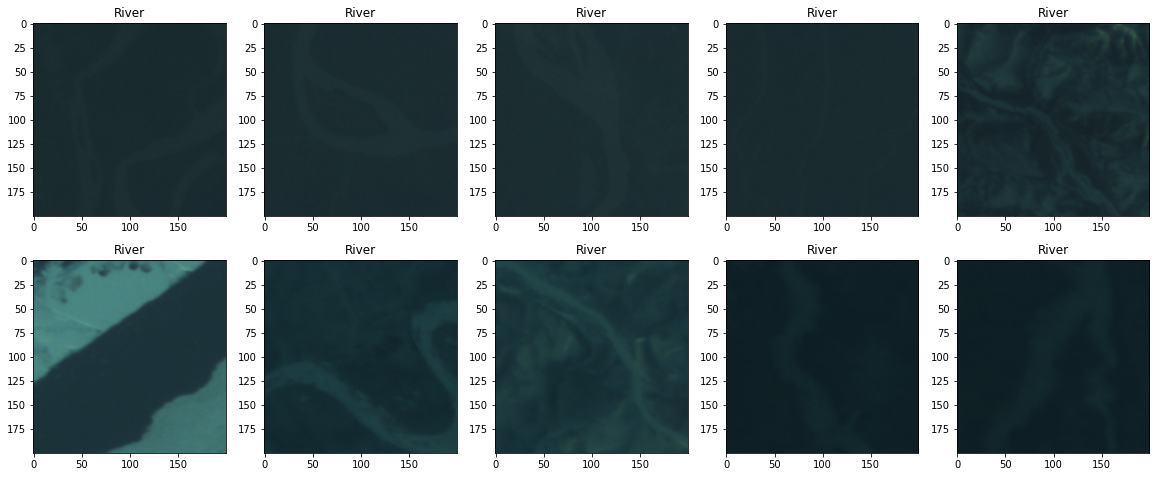

In [25]:
plot_images(x_train, y_train, 4)

### Train val split

In [26]:
step = 10
val_indices = [2,
               4,
               3 + step,
               7 + step,
               3 + 2 * step,
               6 + 2 * step,
               6 + 3 * step,
               8 + 3 * step,
               1 + 4 * step,
               2 + 4 * step,
               3 + 5 * step,
               9 + 5 * step,
               2 + 6 * step,
               4 + 6 * step,
               3 + 7 * step,
               7 + 7 * step]
val_indices

[2, 4, 13, 17, 23, 26, 36, 38, 41, 42, 53, 59, 62, 64, 73, 77]

In [27]:
x_val = x_train[val_indices, :]
y_val = y_train[val_indices]
print(x_val.shape, y_val.shape)

(16, 200, 200, 3) (16,)


In [28]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

Class: 0; Occurrences: 2
Class: 1; Occurrences: 2
Class: 2; Occurrences: 2
Class: 3; Occurrences: 2
Class: 4; Occurrences: 2
Class: 5; Occurrences: 2
Class: 6; Occurrences: 2
Class: 7; Occurrences: 2


In [29]:
x_train = np.delete(x_train, val_indices, axis=0)
y_train = np.delete(y_train, val_indices, axis=0)
print(x_train.shape, y_train.shape)

(64, 200, 200, 3) (64,)


In [30]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

Class: 0; Occurrences: 8
Class: 1; Occurrences: 8
Class: 2; Occurrences: 8
Class: 3; Occurrences: 8
Class: 4; Occurrences: 8
Class: 5; Occurrences: 8
Class: 6; Occurrences: 8
Class: 7; Occurrences: 8


### Augment train images

#### Try out different augmentations

In [31]:
image_to_visualize = 18

Class: Mountain


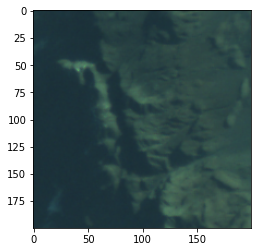

In [32]:
visualize_image(x_train, y_train, image_to_visualize)

#### Flip left right

25 166


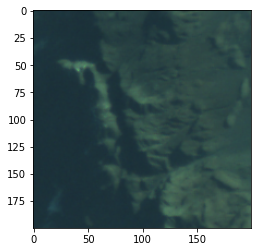

In [33]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
flip_left_right_example = tf.image.stateless_random_flip_left_right(x_train[image_to_visualize], augmentation_seed).numpy().astype(int)
print(flip_left_right_example.min(), flip_left_right_example.max())
plt.imshow(flip_left_right_example)
plt.show()

#### Flip up down

25 166


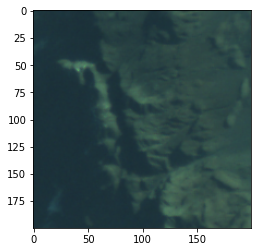

In [34]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
flip_up_down_example = tf.image.stateless_random_flip_up_down(x_train[image_to_visualize], augmentation_seed).numpy().astype(int)
print(flip_up_down_example.min(), flip_up_down_example.max())
plt.imshow(flip_up_down_example)
plt.show()

#### Rotate 90 degrees

25 166


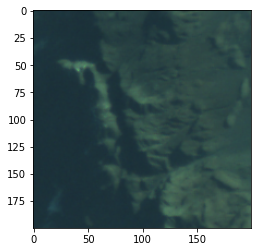

In [35]:
k = random.choice([0, 1, 2, 3])
rot90_example = tf.image.rot90(x_train[image_to_visualize], k=k).numpy().astype(int)
print(rot90_example.min(), rot90_example.max())
plt.imshow(rot90_example)
plt.show()

#### Crop

25 153


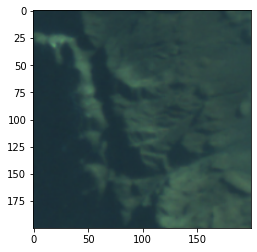

In [36]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
heigth = 200
width = 200
factor = random.choice(np.arange(0.8, 1.05, 0.05))
random_crop_example = tf.image.stateless_random_crop(x_train[image_to_visualize], [int(heigth*factor), int(width*factor), 3], augmentation_seed)
random_crop_example = tf.image.resize(random_crop_example, [heigth, width]).numpy().astype(int)
print(random_crop_example.min(), random_crop_example.max())
plt.imshow(random_crop_example)
plt.show()

#### Brightness

15 156


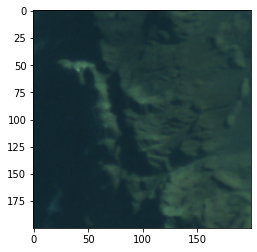

In [37]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
brightness_example = (tf.image.stateless_random_brightness(x_train[image_to_visualize]/255, 0.2, augmentation_seed)*255).numpy().astype(int)
print(brightness_example.min(), brightness_example.max())
plt.imshow(brightness_example)
plt.show()

#### Hue

25 166


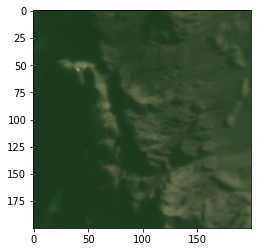

In [38]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
hue_example = tf.image.stateless_random_hue(x_train[image_to_visualize], 0.3, augmentation_seed).numpy().astype(int)
print(hue_example.min(), hue_example.max())
plt.imshow(hue_example)
plt.show()

#### Contrast

24 167


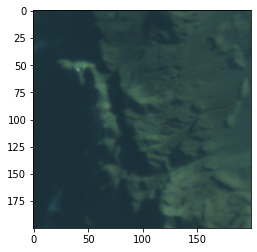

In [39]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
contrast_example = tf.image.stateless_random_contrast(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed).numpy().astype(int)
print(contrast_example.min(), contrast_example.max())
plt.imshow(contrast_example)
plt.show()

#### Saturation

34 166


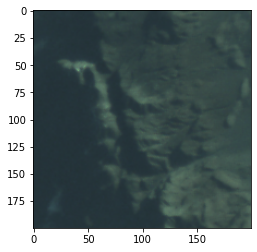

In [40]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
saturation_example = tf.image.stateless_random_saturation(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed).numpy().astype(int)
print(saturation_example.min(), saturation_example.max())
plt.imshow(saturation_example)
plt.show()

#### Noise

0 164


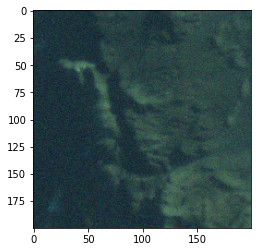

In [41]:
random_noise_example = (random_noise(x_train[image_to_visualize]/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255).astype(int)
print(random_noise_example.min(), random_noise_example.max())
plt.imshow(random_noise_example)
plt.show()

#### Apply augmentations to all train images n times

In [42]:
%%time

num_augmentations = 10

if num_augmentations == 0:
  pass

else:

  x_train_augmented = np.copy(x_train)
  augmentations = np.copy(x_train)

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype(int)
    print(augmentation_seed)

    # flip left right
    augmentations = tf.image.stateless_random_flip_left_right(augmentations, augmentation_seed).numpy().astype(int)

    # flip up down
    augmentations = tf.image.stateless_random_flip_up_down(augmentations, augmentation_seed).numpy().astype(int)

    # rotate 90 degrees
    k = random.choice([0, 1, 2, 3])
    augmentations = np.array([tf.image.rot90(image, k=k) for image in augmentations]).astype(int)

    # crop
    #factor = random.choice(np.arange(0.8, 1.05, 0.05))
    #random_crop = np.array([tf.image.stateless_random_crop(image, [int(heigth*factor), int(width*factor), 3], augmentation_seed) for image in augmentations])
    #augmentations = tf.image.resize(random_crop, [heigth, width]).numpy().astype(int)

    # brigthness
    #augmentations = (tf.image.stateless_random_brightness(augmentations/255, 0.2, augmentation_seed)*255).numpy().astype(int)

    # hue
    #augmentations = tf.image.stateless_random_hue(augmentations, 0.3, augmentation_seed).numpy().astype(int)

    # contrast
    #augmentations = tf.image.stateless_random_contrast(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype(int)

    # saturation
    #augmentations = tf.image.stateless_random_saturation(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype(int)

    # noise
    #augmentations = np.array([random_noise(image/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255 for image in augmentations]).astype(int)

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train] * (num_augmentations + 1))

[18854 11114]
[ 8657 62798]
[30893 33932]
[22261  5949]
[ 8032 57878]
[34503 10147]
[30069 63841]
[56831 12862]
[24431 64371]
[51024 50923]
CPU times: user 5.43 s, sys: 1.03 s, total: 6.46 s
Wall time: 5.87 s


In [43]:
x_train.shape

(64, 200, 200, 3)

In [44]:
augmentations.shape

(64, 200, 200, 3)

In [45]:
x_train_augmented.shape

(704, 200, 200, 3)

In [46]:
y_train.shape

(64,)

In [47]:
y_train_augmented.shape

(704,)

In [48]:
# remove duplicate augmentations
x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
y_train_augmented = y_train_augmented[indices]
print(x_train_augmented.shape, y_train_augmented.shape)

(246, 200, 200, 3) (246,)


#### Check augmentations

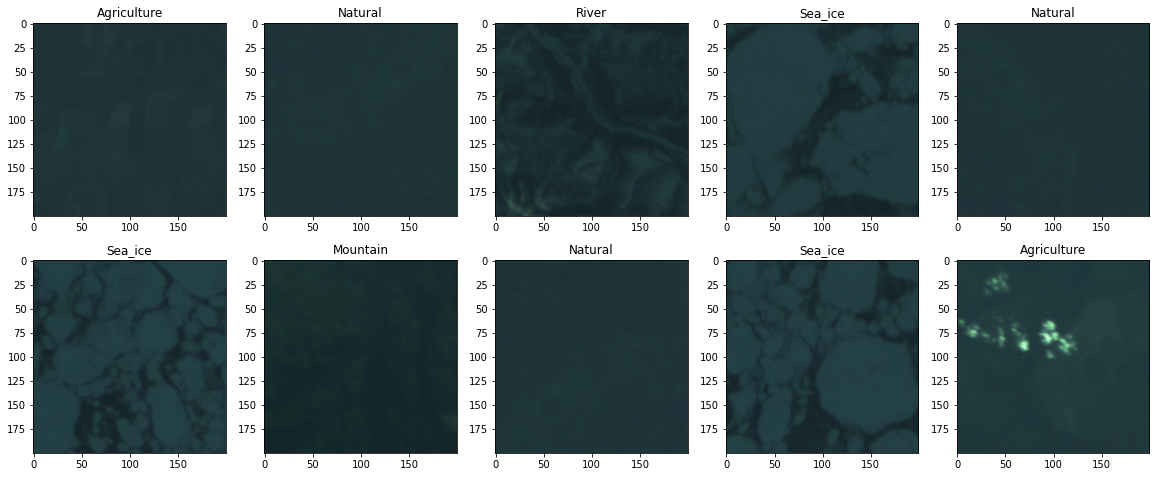

In [49]:
plot_images(x_train_augmented, y_train_augmented, 10)

### Shuffle and convert images and labels

In [50]:
if num_augmentations == 0:
  x_train, y_train = shuffle(x_train, y_train, random_state=seed)
  x_train = tf.convert_to_tensor(x_train)
  y_train = tf.convert_to_tensor(y_train, dtype=np.int32)

else:
  x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented, random_state=seed)
  x_train = tf.convert_to_tensor(x_train_augmented)
  y_train = tf.convert_to_tensor(y_train_augmented, dtype=np.int32)

  del x_train_augmented, y_train_augmented
  gc.collect()

x_val, y_val = shuffle(x_val, y_val, random_state=seed)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val, dtype=np.int32)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(246, 200, 200, 3) (246,) (16, 200, 200, 3) (16,)


# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [53]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val, y_val), shuffle=False)

Epoch 1/100
31/31 [==============================] - 13s 106ms/step - loss: 4.9600 - sparse_categorical_accuracy: 0.1870 - val_loss: 77.8870 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/100
31/31 [==============================] - 2s 61ms/step - loss: 4.5175 - sparse_categorical_accuracy: 0.1911 - val_loss: 9.1392 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/100
31/31 [==============================] - 2s 61ms/step - loss: 3.5434 - sparse_categorical_accuracy: 0.2358 - val_loss: 4.6718 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/100
31/31 [==============================] - 2s 59ms/step - loss: 3.2899 - sparse_categorical_accuracy: 0.2439 - val_loss: 5.2207 - val_sparse_categorical_accuracy: 0.1250
Epoch 5/100
31/31 [==============================] - 2s 60ms/step - loss: 2.7964 - sparse_categorical_accuracy: 0.2846 - val_loss: 8.5681 - val_sparse_categorical_accuracy: 0.1250
Epoch 6/100
31/31 [==============================] - 2s 59ms/step - loss: 2.8062 - sparse_categor

### Plot loss and accuracy

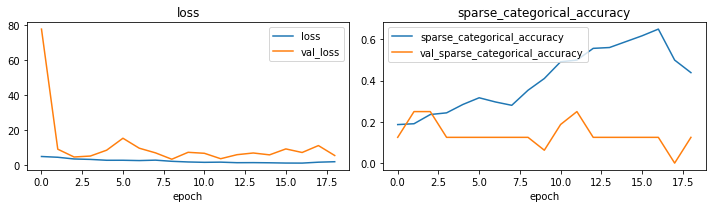

In [54]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

In [55]:
print('min val loss: {}'.format(round(min(history.history['val_loss']), 3)))

min val loss: 3.395


Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [56]:
%%time
predictions = evaluate_model(x_train, y_train)

Score: 0.9208605891027338
CPU times: user 11.7 s, sys: 554 ms, total: 12.2 s
Wall time: 12.2 s


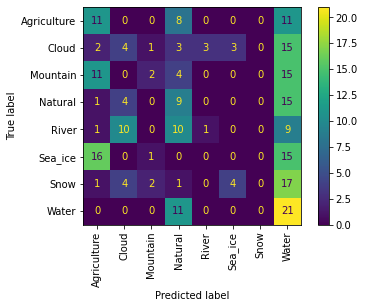

In [57]:
get_confusion_matrix(y_train, predictions)

In [58]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

Accuracy: 0.195
Precision: 0.195
Recall: 0.195
F1-Score: 0.195
              precision    recall  f1-score   support

           0       0.26      0.37      0.30        30
           1       0.18      0.13      0.15        31
           2       0.33      0.06      0.11        32
           3       0.20      0.31      0.24        29
           4       0.25      0.03      0.06        31
           5       0.00      0.00      0.00        32
           6       0.00      0.00      0.00        29
           7       0.18      0.66      0.28        32

    accuracy                           0.20       246
   macro avg       0.17      0.19      0.14       246
weighted avg       0.18      0.20      0.14       246



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class: Water
Predicted: Water


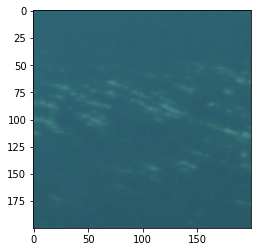

In [59]:
visualize_image(x_train.numpy().astype(int), y_train.numpy(), image_to_visualize, pred=True, predictions=predictions)

### Evaluation on val set

In [60]:
%%time
predictions = evaluate_model(x_val, y_val)

Score: 1.0
CPU times: user 1.21 s, sys: 47.5 ms, total: 1.26 s
Wall time: 1.25 s


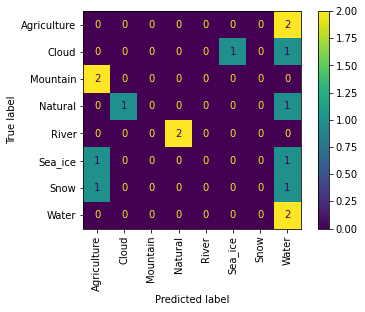

In [61]:
get_confusion_matrix(y_val, predictions)

In [62]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

Accuracy: 0.125
Precision: 0.125
Recall: 0.125
F1-Score: 0.125
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.25      1.00      0.40         2

    accuracy                           0.12        16
   macro avg       0.03      0.12      0.05        16
weighted avg       0.03      0.12      0.05        16



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print('Predicted {} images out of {} correctly.'.format(int(round(metrics.accuracy_score(y_val, predictions) * x_val.shape[0], 0)), x_val.shape[0]))

Predicted 2 images out of 16 correctly.


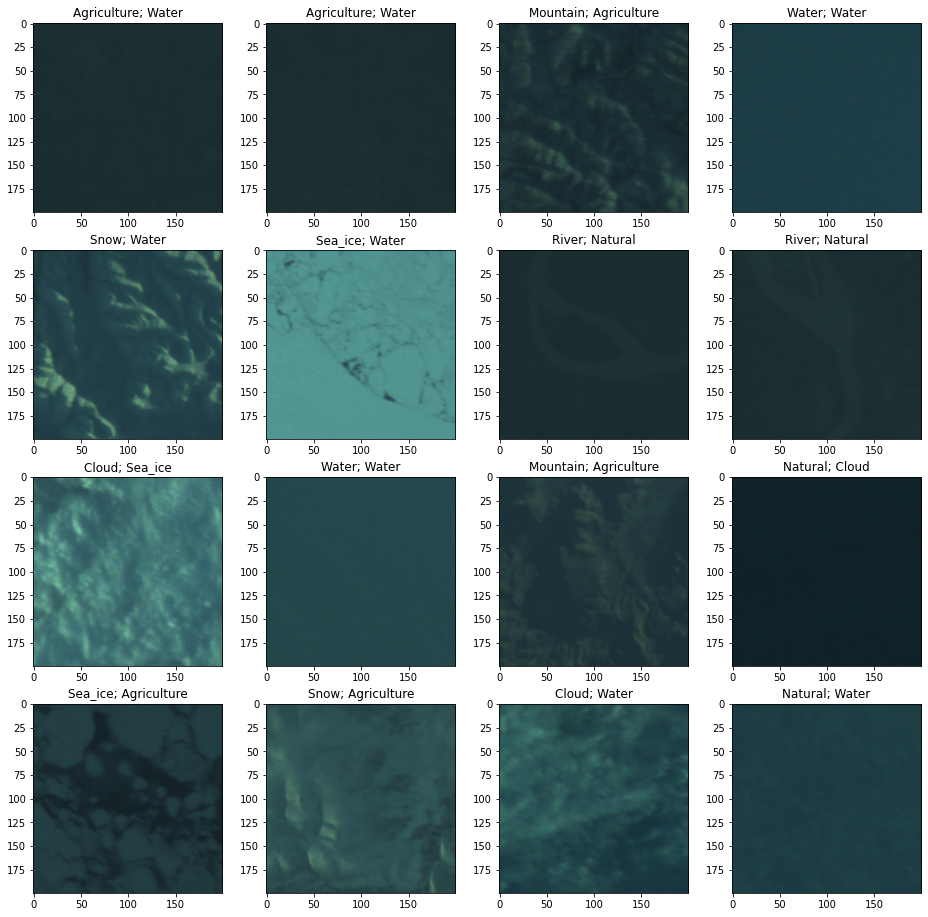

In [64]:
plot_val_images_and_predictions(x_val.numpy(), y_val.numpy(), predictions)

# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [65]:
#Saving model
#model.save_weights('v31.h5')

The trained model can be also loaded for further testing. 

In [66]:
#model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
#model.load_weights('v31.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [67]:
#Model shall be compiled before testing.
#model.compile()

#predictions = evaluate_model(x_train, y_train)

In [68]:
# retrain model using all images
!time python train.py

2022-10-08 21:42:42.525781: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Found 80 files belonging to 8 classes.
[13275 39902]
[ 7104 18506]
[13725 43738]
[34687 36169]
[65446 53196]
[  775 25597]
[50919 15377]
[18854 11114]
[ 8657 62798]
[30893 33932]
x train shape: (307, 200, 200, 3); y train shape: (307,)
Epoch 1/55
39/39 [==============================] - 10s 69ms/step - loss: 4.6866 - sparse_categorical_accuracy: 0.1596
Epoch 2/55
39/39 [==============================] - 2s 54ms/step - loss: 3.9312 - sparse_catego